## Grover's Algorithm
- Practicing grover's algorithm for an *n-qubit* search problem 
- We know that the sign flip oracle is $U_f$ and the diffuser is $U_d$.
- Let us try to build a basic n-qubit grover search with a randomized winning state
- Note, that although this is a trivial problem but making it by hand helps to practice the concepts
- Let us start!

In [55]:
from qiskit import *
from qiskit.quantum_info import Operator 
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
from qiskit.providers.ibmq import IBMQ

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q-education')

In [4]:
sim = BasicAer.get_backend('qasm_simulator')
sv_sim = BasicAer.get_backend('statevector_simulator')

### 1. Starting out with creating a random winning state 
- We shall create a function which - 
    - Takes in an input bit size $n$
    - Takes in how many winning states $w$ we need to generate
    - Returns the randomly chosen winning states and the complete list 


In [42]:
def get_winners(n, winners):
    assert(winners <= 2**n), "Number of winners must be less than 2**{}".format(n)

    choices = np.random.choice(2**n, winners)
    res = [0 for i in range(2**n)]
    
    for k in choices:
        res[k] = 1    
    return {"winners": list(choices), "list ":res }

In [43]:
get_winners(3, 1)

{'winners': [7], 'list ': [0, 0, 0, 0, 0, 0, 0, 1]}

### 2. Initialization of Grover circuit
- Given the number of bits and number of winning states, we build our -
    - Initial equal superposition circuit 
    - Initia oracle $U_f$ for the phase flip on the target states / winning states

In [116]:
def get_oracle(n,winners):
    matrix = np.eye(2**n)
    # make the Uf oracle matrix
    for i in winners:
        try:
            matrix[i][i] = -1
        except:
            print("Invalid winner states")
    
    # construct the operator 
    op = Operator(data = matrix)  
    
    #construct the quantum circuit
    qc = QuantumCircuit(n,name='Uf oracle')
    qc = qc.compose(op, qubits = range(n))
    qc = qc.control(num_ctrl_qubits=1, ctrl_state='1')
    
    return qc 

In [117]:
o = get_oracle(3,[0,5])

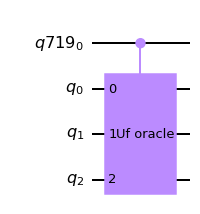

In [118]:
o.draw('mpl')

### 3. Making the diffuser
- The diffuser circuit is the next most important thing in the circuit generation 
- We make the diffuser circuit using the following identity - 
$$U_d = 2|s \rangle \langle s| - I$$
- In the above equation, $|s\rangle$ is the equal superposition state of the circuit

In [149]:
def make_diffuser(n):
    # only the size of the circuit is required to make 
    # |s> state 
    
    h = (1/np.sqrt(2))*np.array([[1,1],
                      [1,-1]])
    hn = h
    # do tensor n-1 times 
    for i in range(n-1):
        hn = np.kron(hn,h)
        
    print(n,"qubit hadamard transform")
    print(hn)
    
    # built the hadamard circuit
    # first column is the equal superposition state or just the first row as transpose is equal
    s_state = np.array([hn[0]])
    
    #build diffuser 
    diffuser = 2* (s_state.transpose() @ s_state) - np.eye(2**n)
    
    op = Operator(data = diffuser)
    
    print("Diffuser :",op)

In [150]:
make_diffuser(3)

3 qubit hadamard transform
[[ 0.35355339  0.35355339  0.35355339  0.35355339  0.35355339  0.35355339
   0.35355339  0.35355339]
 [ 0.35355339 -0.35355339  0.35355339 -0.35355339  0.35355339 -0.35355339
   0.35355339 -0.35355339]
 [ 0.35355339  0.35355339 -0.35355339 -0.35355339  0.35355339  0.35355339
  -0.35355339 -0.35355339]
 [ 0.35355339 -0.35355339 -0.35355339  0.35355339  0.35355339 -0.35355339
  -0.35355339  0.35355339]
 [ 0.35355339  0.35355339  0.35355339  0.35355339 -0.35355339 -0.35355339
  -0.35355339 -0.35355339]
 [ 0.35355339 -0.35355339  0.35355339 -0.35355339 -0.35355339  0.35355339
  -0.35355339  0.35355339]
 [ 0.35355339  0.35355339 -0.35355339 -0.35355339 -0.35355339 -0.35355339
   0.35355339  0.35355339]
 [ 0.35355339 -0.35355339 -0.35355339  0.35355339 -0.35355339  0.35355339
   0.35355339 -0.35355339]]
Diffuser : Operator([[-0.75+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,
            0.25+0.j,  0.25+0.j,  0.25+0.j],
          [ 0.25+0.j, -0.75+0.j,  0.25+0.j

### more, to-do...